In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

First, let us build a function to create random periodic signals.

In [2]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

Generate a signal with $A = 2$ and $p = \pi$ over a regular grid between 0 and 10. Plot your results to confirm your code from the previous problem. 

<IPython.core.display.Javascript object>


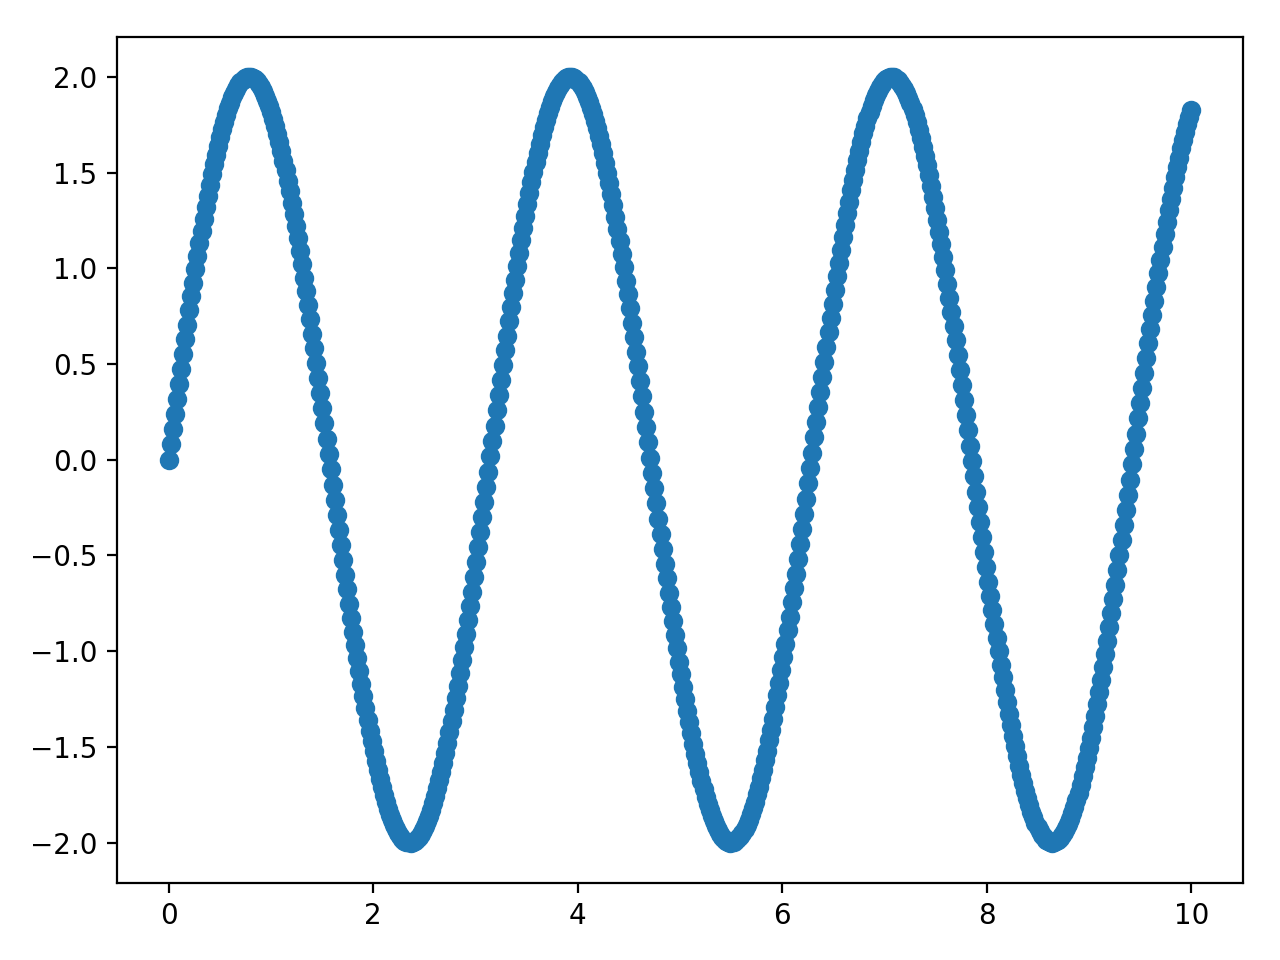

In [26]:
x = np.linspace(0,10,500)
y = gen_periodic_data(x, period=np.pi,amplitude=2)

fig, ax = plt.subplots()
ax.scatter(x,y)
fig.tight_layout()

Now, generate a function to plot phase folded data which takes x, y, period, and y uncertainties as input.

In [72]:
def phase_plot(x, y, period, y_unc = 0.0):
    
    phases = (x/period) % 1
    if len(y_unc) == 1:
        y_unc = np.zeros_like(x)
    
    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o')
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    fig.tight_layout()

Plot the phase folded light curve for the previously generated data.

<IPython.core.display.Javascript object>


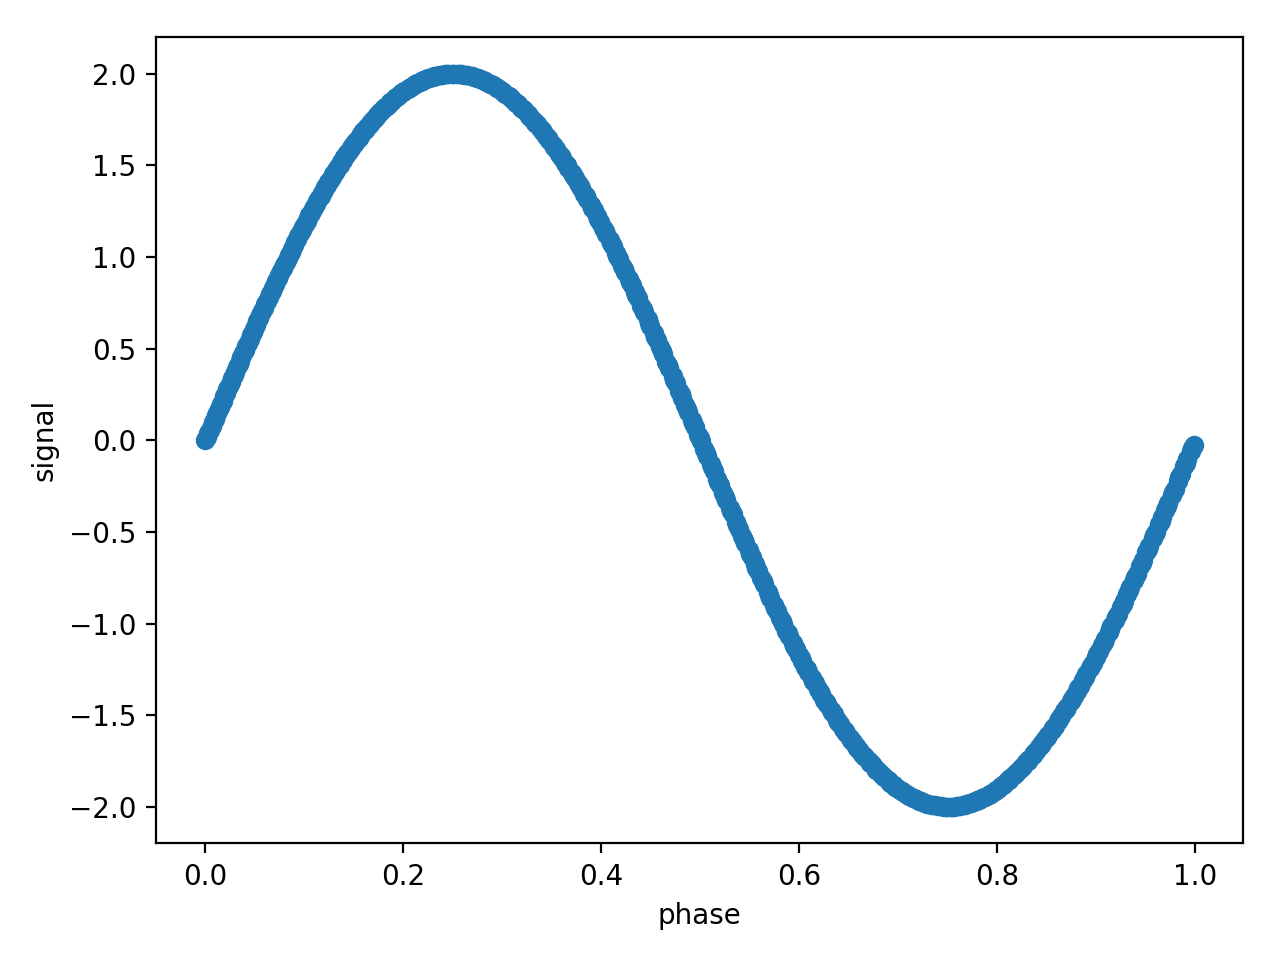

In [28]:
phase_plot(x, y, np.pi)

Now that we have those two basic steps out of the way, we are going to transition into the detection of periodic signals in data.

In astronomy, this is typically done with the Lomb-Scargle (LS) periodogram ([Lomb 19xx](); [Scargle 19xx]()). To understand how to interpret the LS periodogram, we first need to consider Fourier transforms.

*Note - here we aim to jog your memory regarding Fourier analysis. Detailed mathematical calculations can be found elsewhere.*

Given a continuous signal, $g(t)$ the Fourier transform of that signal is defined as:

$$\hat{\mathrm{g}}(f) = \int_{-\infty}^{\infty} g(t) \,e^{-2\pi i f t} \,dt,$$

where $i$ is an imaginary number. The inverse of this equation is defined as:

$$ g(t) = \int_{-\infty}^{\infty} \hat{\mathrm{g}}(f) \,e^{-2\pi i f t} \,dt.$$

For convenience, we will use the Fourier transform operator $\mathcal{F}$, from which the above equations reduce to: 

$$\mathcal{F}(g) = \hat g$$

$$\mathcal{F}^{-1}(\hat{g}) = g$$

There are many useful properties of the Fourier transform including that the Fourier transform is a linear operator. Additionally, a time shift imparts a phase shift. Perhaps most importantly for our present purposes, however, is that the squared amplitude of the resulting transform allows us to get rid of the imaginary component and measure the power spectral density or power spectrum:

$$ \mathcal{P}_g = |\mathcal{F}(g)|^2.$$

The power spectrum is a real-valued function that quantifies the contribution of each frequency $f$ to the total signal in $g$. The power spectrum thus provides a way to identify the dominant frequency in any given signal. 

Next we consider some common Fourier pairs, that will prove helpful in our interpretation of the LS periodogram. 

<IPython.core.display.Javascript object>


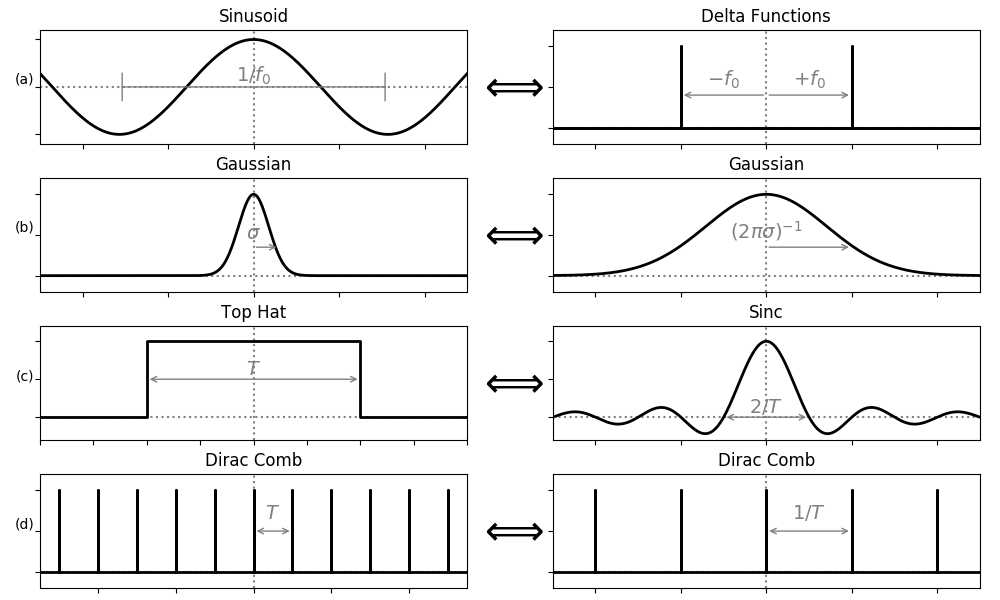

In [29]:
fourier_pairs_plot()

The final property of the Fourier transform to consider today is the convolution theorem. Fourier transforms convert convolutions into point-wise products. We define a convolution as:

$$ [f \ast g] (t) = \int_{-\infty}^{\infty} f(\tau) \,g(t - \tau) \,d\tau,$$

where $\ast$ is the convolution symbol. From the convolution theorem:

$$ \mathcal{F} \{f \ast g\} = \mathcal{F}(f)  \mathcal{F}(g) $$

Furthermore, the Fourier transform of a product is equal to the convolution of the Fourier transforms:

$$ \mathcal{F}\{f \cdot g\} = \mathcal{F}(f) \ast \mathcal{F}(g) $$

This property will be very important for understanding the Lomb-Scargle periodogram. 

Fourier transforms are all well and good, but ultimately we desire a measure of periodicity in actual observations of astrophysical sources, which cannot be (a) continuous, or (b) infinite. 

The first thing to understand with real world observations is the Nyquist frequency limit. If observations are obtained in a uniformly spaced manner at a rate of $f_0 = 1/T$ one can only recover the frequncy information if the signal is band-limited between frequencies $\pm f_0/2$. Put another way, the highest frequency that can be detected in such data is $f_0/2$.

This result can be (somewhat) intuited by looking at simulated data. Let us return to our generating functions from before. 

Generate and plot a periodic signal with $f = f_\mathrm{Ny} = 1/2$ on a grid from 0 to 10, comprising of 10 even samples (i.e., 0, 1, 2, 3, ..., 10). Overplot the underlying signal in addition to the observations.

<IPython.core.display.Javascript object>


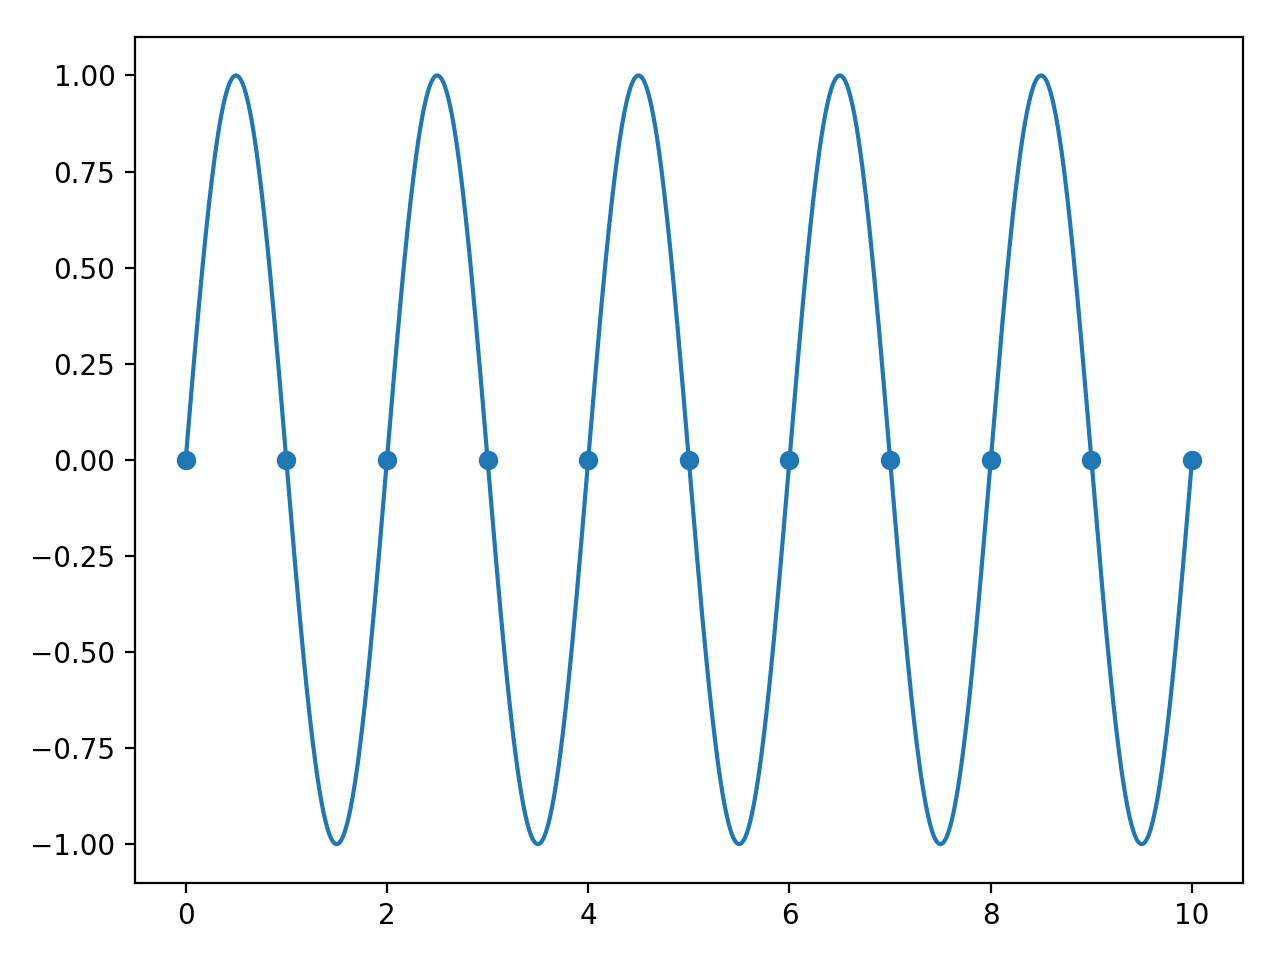

In [10]:
x = np.linspace(0,10,11)
y = gen_periodic_data(x, period=2)
x_signal = np.linspace(0,10,1000)
y_signal = gen_periodic_data(x_signal, period=2)
plt.figure()
plt.scatter(x,y)
plt.plot(x_signal, y_signal)
plt.tight_layout()

Sampling a signal directly at the Nyquist frequency results in a lack of any signal detection. 

What about frequencies higher than the Nyquist frequency?

Repeat the exercise above, but for a signal with $f = 0.7$.

<IPython.core.display.Javascript object>


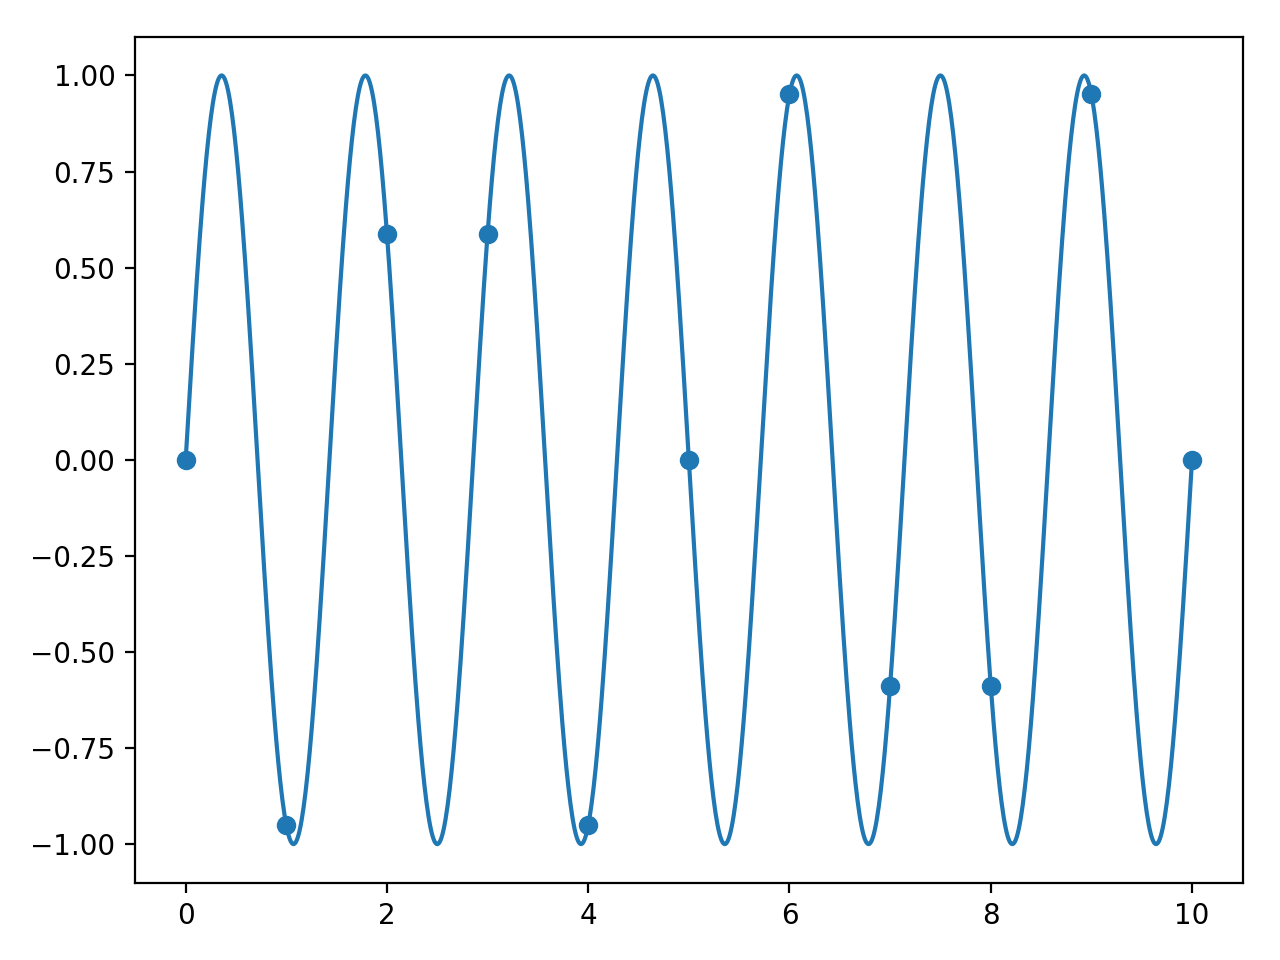

In [11]:
x = np.linspace(0,10,11)
y = gen_periodic_data(x, period=1/0.7)
x_signal = np.linspace(0,10,1000)
y_signal = gen_periodic_data(x_signal, period=1/0.7)
plt.figure()
plt.scatter(x,y)
plt.plot(x_signal, y_signal)
plt.tight_layout()

Variability can be seen in this signal. However, there are fewer than 2 observations per cycle. To see why this is problematic, create the same plot as above and overplot a source with $f = 2.7$.

<IPython.core.display.Javascript object>


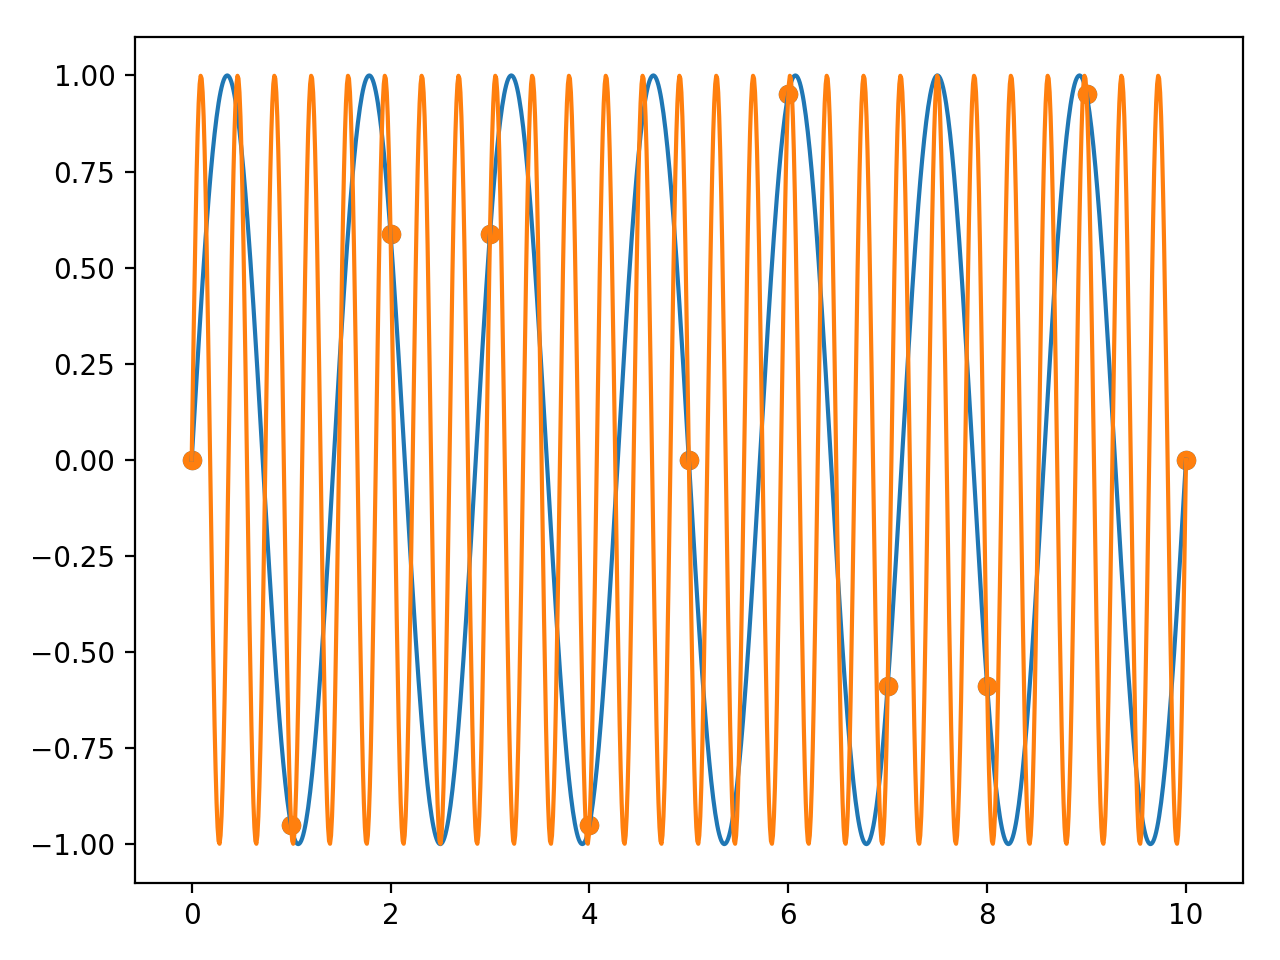

In [12]:
x = np.linspace(0,10,11)
y = gen_periodic_data(x, period=1/0.7)
x_signal = np.linspace(0,10,1000)
y_signal = gen_periodic_data(x_signal, period=1/0.7)
plt.figure()
plt.scatter(x,y)
plt.plot(x_signal, y_signal)

y_high = gen_periodic_data(x, period=1/2.7)
y_signal_high = gen_periodic_data(x_signal, period=1/2.7)
plt.scatter(x,y_high)
plt.plot(x_signal, y_signal_high)
plt.tight_layout()

In this case the observations are identical! Practically speaking, what is the importance of the Nyquist frequency:

  1. If you are going to obtain observations at *regular intervals*, and there is a specific signal you wish to detect, then be sure to sample the data such that $f_\mathrm{Ny} > f_\mathrm{signal}$.
  2. For all $f > f_\mathrm{Ny}$, $f$ will be aliased with all signals with $f \pm 2n f_\mathrm{Ny}$, where $n$ is an integer. Practically speaking, this means it does not make sense to search for signals with $f > f_\mathrm{Ny}$.
  3. Finally, (and this is something that is often wrong in the literature) there is no Nyquist limit for unevenly sampled data (see Van der Plas 2013 for further details). Thus, for ground based telescopes one need not worry about the Nyquist limit.

Staying on the topic of non-continuous observations, I present without derivation the discrete Fourier transform:

$$ \hat g_\mathrm{obs}(f) = \sum_{n = 0}^N g_n\,e^{-2\pi i f n\Delta t}$$

where $g_n = g(n\Delta t)$, and $\Delta t$ is the sampling interval. Our discussion of the Nyquist frequency tells us that we cannot detect frequencies $f > 1/2\Delta T$. Thus, the relevant frequencies to search for power given $\Delta t$ are between 0 and $f_\mathrm{Ny}$, which we can sample on a grid $\Delta f = 1/(N \Delta t)$. From there:

$$\hat g_k = \sum_{n = 0}^N g_n\,e^{-2\pi i f knN}$$

where $\hat g_k = \hat g_\mathrm{obs} (k\Delta f)$. This is the discrete Fourier transform. 

I said a full derivation will not be provided, and that is true. To understand how we went from a continuous integral to the summation above, recall that regular observations of a continous signal over a finite interval is equivalent to multiplying the continuous signal by a Dirac comb function and a window function. The delta functions from the Dirac comb function collapse the integral to a sum, while the window function limits that sum from $0$ to $N$.

From the discrete Fourier transform we can then calculate the periodogram (an estimator of the power spectrum):

$$\mathcal{P}(f) = \frac{1}{N}\left|\sum_{n=1}^{N} g_n\,e^{-2\pi i f knN}\right|^2$$

which is also called the classical periodogram or the Schuster periodogram (Schuster 1898). 

Of course, we ultimately care about applications where the data are not uniformly sampled (even *Kepler* data is not uniformly sampled). We can re-write the classical periodogram in a more general way:

$$\mathcal{P}(f) = \frac{1}{N}\left|\sum_{n=1}^{N} g_n\,e^{-2\pi i f t_n}\right|^2$$

where $t_n$ corresponds to the observation times. Irregular sampling removes a lot of the nice statistical properties of the discrete Fourier transform. Scargle (1982) was able to address these issues via a generalized form of the periodogram. 

[For completeness, there are some long equations that I should include here, but I won't...]

Instead, I will simply things slightly by using the fact that Scargle's modified periodogram is identical to the result one obtains by fitting a sinusoid model to the data at each frequency $f$ and constructing a "periodogram" from the corresponding $\chi^2$ values at each frequency $f$ [this was considered in great detail by Lomb (1976)]. 

Thus, using the model:

$$y(t;f) = A_f \sin(2\pi f(t - \phi_f)$$

we can calculate the $\chi^2$ for every frequency $f$:

$$\chi^2 = \sum_n (y_n - y(t_n; f))^2$$

The "best" model for a given frequency requires the selection of $A_f$ and $\phi_f$ that minimizes $\chi^2$, which we will call $\hat \chi^2$. Scargle (1982) then showed that the Lomb-Scargle periodogram can be written 

$$\mathcal{P}_\mathrm{LS}(f) = \frac{1}{2}\left[ \hat \chi^2_0 - \hat \chi^2(f) \right]$$

where $\hat \chi^2_0$ is the value for a non-varying reference model.

This realization enables the inclusion of observational uncertainty in the periodogram, via a familiar adjustment to the $\chi^2$ value:

$$\chi^2 = \sum_n \left(\frac{y_n - y(t_n; f)}{\sigma_n}\right)^2$$



From here it follows that we can construct a LS periodogram. 

Write a short function to calculate the $\chi^2$ given observations $y_n$ with uncertainties $\sigma_{y,n}$ taken at times $t_n$ for frequency $f$. 

In [14]:
def chi2(theta, y, y_unc, x, f):
    a = theta[0]
    phi = theta[1]
    return np.sum(((y - a*np.sin(2*np.pi*f*(x-phi)))/y_unc)**2)

Write a function to minimize the $\chi^2$ given everything but $A_f$ and $\phi_f$.

In [15]:
from scipy.optimize import minimize

def min_chi2(theta, y, y_unc, x, f):
    res = minimize(chi2, theta, args = (y, y_unc, x, f))
    return res.fun

Write a function to calculate the LS periodogram for observations $y$, $\sigma_y$, $t$ over a frequency grid `f_grid`.

In [16]:
def ls_periodogram(y, y_unc, x, f_grid):
    psd = np.empty_like(f_grid)
    chi2_0 = np.sum(((y - np.mean(y))/y_unc)**2)
    for f_num, f in enumerate(f_grid):
        psd[f_num] = 0.5*(chi2_0 - min_chi2([0,0], y, y_unc, x, f))
    
    return psd

Generate a periodic signal with 100 observations taken over a time period of 10 days. Use an input period of 5.25, amplitude of 7.4, and variance of the noise = 0.8. Then compute and plot the periodogram for the simulated data. Do you recover the simulated period?

*Hint* - set the minimum frequency in the grid to $1/T$ where $T$ is the duration of the observations. Set the maximum frequnecy to 10, and use an equally spaced grid with 50 points. 

In [63]:
np.random.seed(23)
x = 10*np.random.rand(100)
y = gen_periodic_data(x, period=5.27, amplitude=7.4, noise=0.8)
y_unc = np.random.normal(0,np.sqrt(0.8), size=len(x))

f_grid = np.linspace(1/np.ptp(x), 10,50)

psd_ls = ls_periodogram(y, y_unc, x, f_grid)

<IPython.core.display.Javascript object>


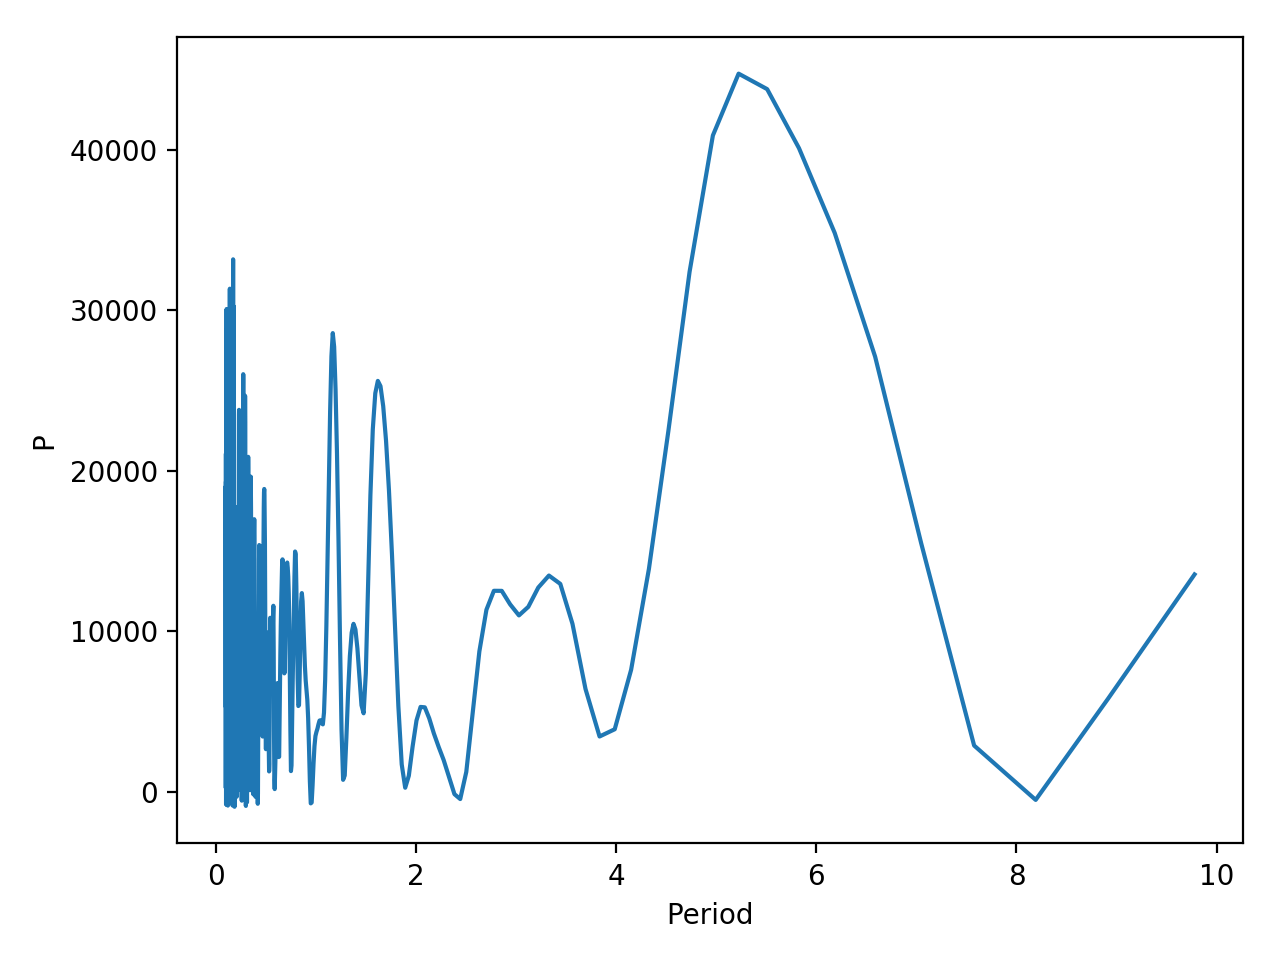

In [68]:
plt.figure()
plt.plot(1/f_grid, psd_ls)
plt.ylabel('P')
plt.xlabel('Period')
plt.tight_layout()

For the same data, include 1000 points in the grid and calculate and plot the periodogram. Did you recover the period with greater accuracy?

In [65]:
f_grid = np.linspace(1/np.ptp(x), 10,1000)

psd_ls = ls_periodogram(y, y_unc, x, f_grid)

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/adamamiller/m

<IPython.core.display.Javascript object>


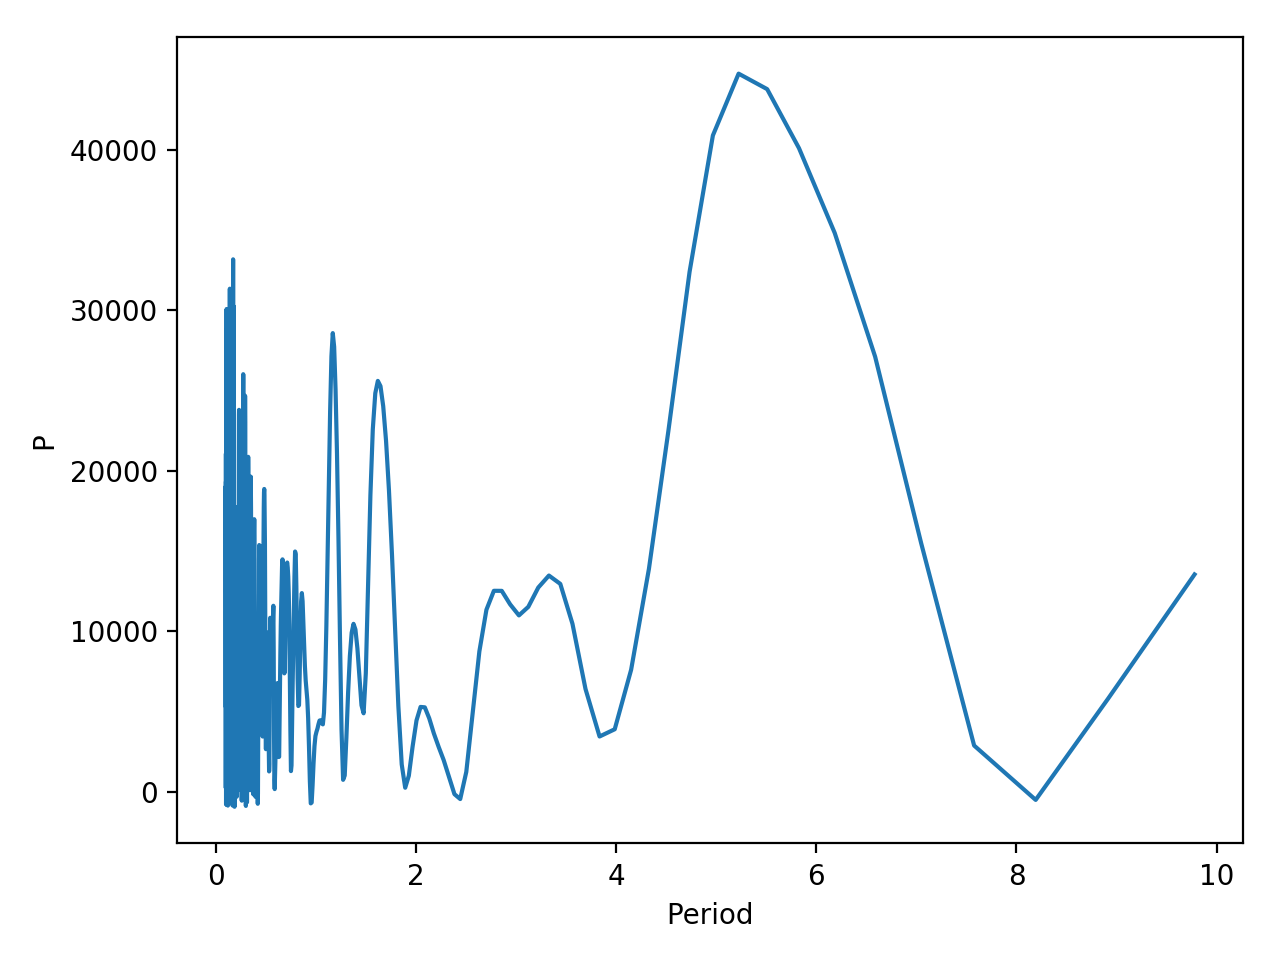

The best fit period is: 5.2239


In [66]:
fig,ax = plt.subplots()

ax.plot(1/f_grid, psd_ls)
ax.set_ylabel('P')
ax.set_xlabel('Period')
fig.tight_layout()

print("The best fit period is: {:.4f}".format(1/f_grid[np.argmax(psd_ls)]))

Plot the phase-folded data at the "best" fit period.

<IPython.core.display.Javascript object>


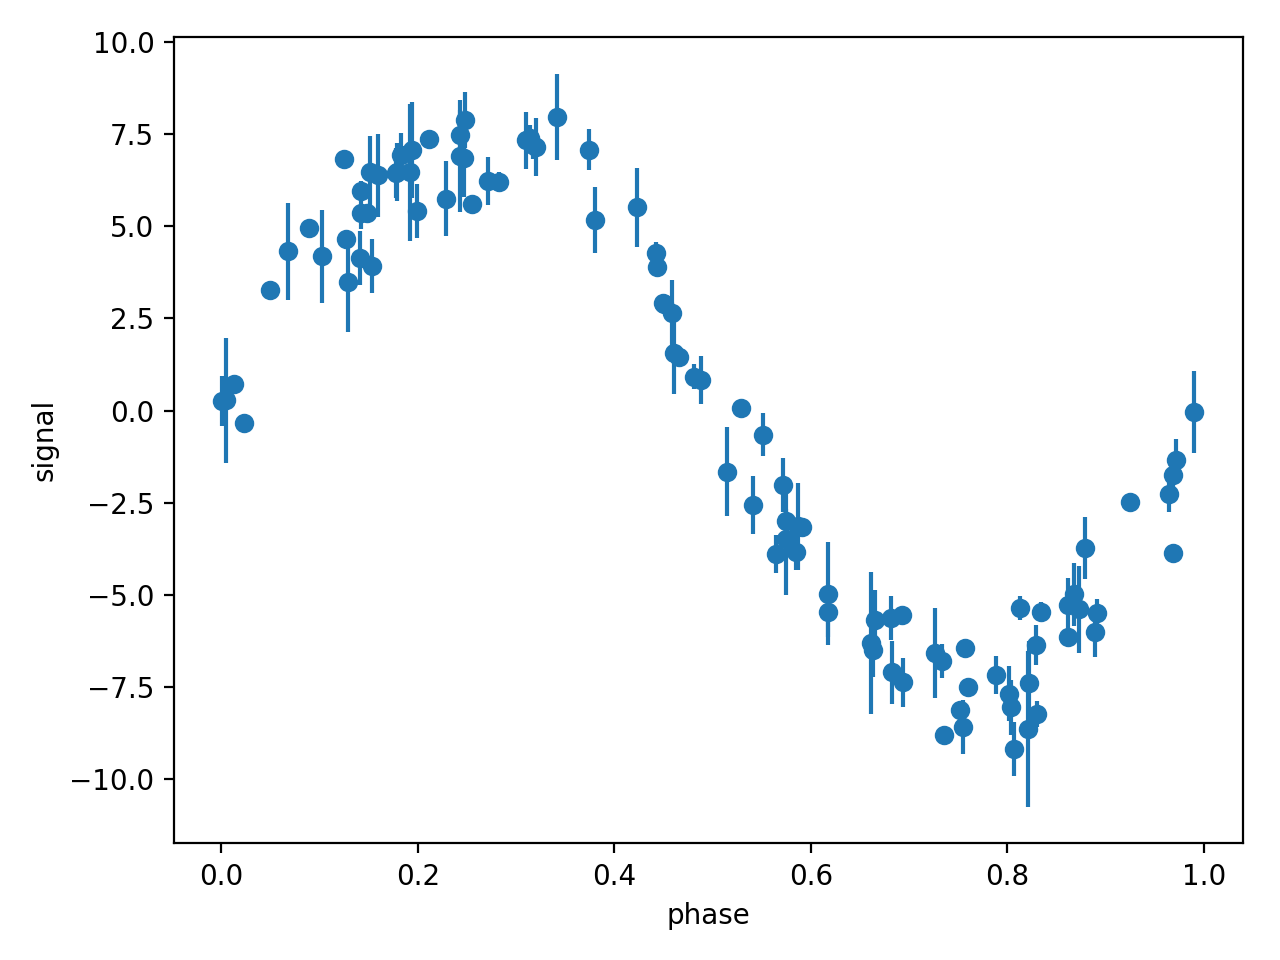

In [73]:
phase_plot(x, y, 1/f_grid[np.argmax(psd_ls)], y_unc)

## Congratulations

You did it! You have constructed the software necessary to find periodic signals in sparsely sampled, noisy data.

You are ready to conquer LSST.

**But wait!**

There should be a few things that are bothering you. 

First and foremost, why did we use a grid with 50 points and then increase that to 1000 points for the previous simulation?

There are many important ramifications following the choice of an evaluation grid for the LS periodogram. When selecting the grid upon which to evaluate $f$ one must determine both the limits for the grid and the spacing within the grid. 

The minimum frequency is straightforward: $f_\mathrm{min} = 1/T$ corresponds to a signal that experiences 1 cycle in the span of the data. Computationally, $f_\mathrm{min} = 0$ does not add much time. 

The maximum frequency is straightforward: $f_\mathrm{Ny}$ (**if** you have evenly spaced data). What if the data are not evenly spaced (a situation for which we said $f_\mathrm{Ny}$ does not exist? 

There are many ad-hoc methods described in the literature, such as $f_\mathrm{max} = 1/<\Delta T>$, where $<\Delta T>$ is the mean separationn of consecutive observations. Again - this is *not* correct.

[Van der Plas (2017)](https://arxiv.org/abs/1703.09824) discuss maximum frequencies for non-uniform data (see that paper for more details). My useful practical advice is to set $f_\mathrm{max}$ to the maximum frequency that you might expect to see in the data (for example, with the exception of a few extreme white dwarf systems, essentially no stars show periodicity at $< 1\,\mathrm{hr}$).

Of course, we still haven't decided what grid to adopt. As we saw above - if we use too few points, we will not resolve the peak in the periodogram. Alternatively, if we include too many points in the grid we will waste a lot of computation. 

Fortunately, figuring out $\Delta f$ is relatively straightfoward: from above we saw that the Fourier transform of a window function of length $T$ produces a sinc signal with width $\sim 1/T$. Thus, we need $\Delta f$ to sample $\sim 1/T$, which means $\Delta f = 1/n_0T$, where $n_0$ is a constant, and 5 is a good choice for $n_0$.

Calculate the optimal grid for sampling LSST data. Assume that the time measurements are carried out in units of days, the survey lasts for 10 years and the shortest period expected in the data is 1 hr. 

How many evaluations are needed to calculate the periodogram?

In [74]:
f_min = 1/(365*10)
f_max = 1/(1/24)
delta_f = f_min/5

f_grid = np.arange(f_min, f_max, delta_f)

print("{:d} grid points are needed to sample the periodogram".format(len(f_grid)))

437995 grid points are needed to sample the periodogram


## Other Considerations and Faster Implementations

While the code developed above functions well, it would take a long time to evaluate $\sim 4\times 10^5$ frequencies for $\sim 2\times 10^7$ variable LSST sources. Fortunately, there are significantly faster implementations, including (as you may have guessed) one in `astropy`.

[`LombScargle`](http://docs.astropy.org/en/stable/stats/lombscargle.html) in `astropy.stats` is fast and has many options to improve speed. 

In [75]:
from astropy.stats import LombScargle
frequency, power = LombScargle(x, y, y_unc).autopower()

Unlike our procedure, `LombScargle` effectively takes no time to run on the simulated data. 

Plot the periodogram for the simulated data. 

<IPython.core.display.Javascript object>


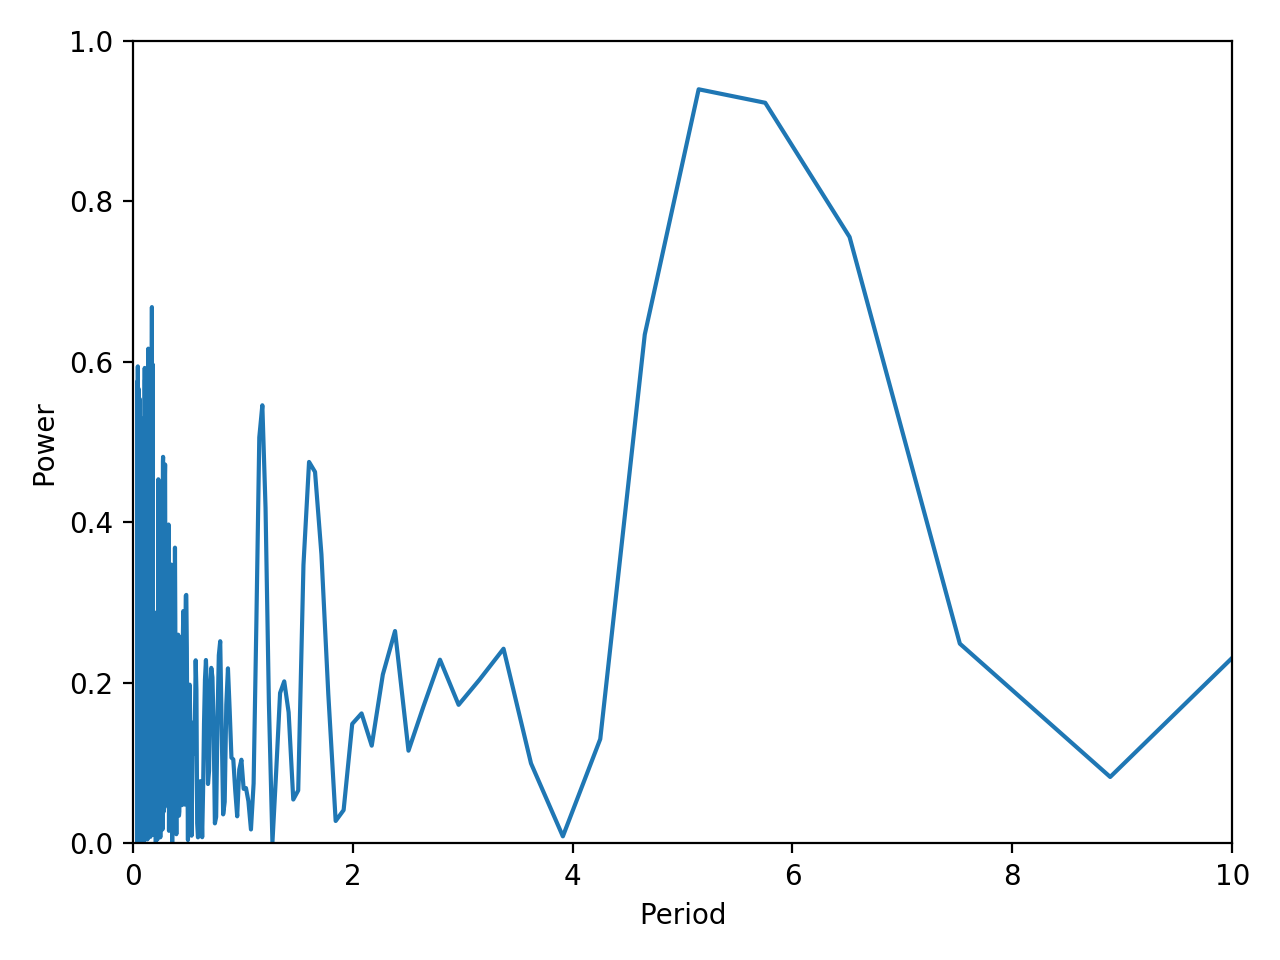

In [76]:
fig, ax = plt.subplots()

ax.plot(1/frequency, power)
ax.set_ylabel('Power')
ax.set_xlabel('Period')
ax.set_xlim(0,10)
ax.set_ylim(0,1)
fig.tight_layout()

There are many choices regarding the calculation of the periodogram, so [read the docs](http://docs.astropy.org/en/stable/api/astropy.stats.LombScargle.html#astropy.stats.LombScargle).

### Floating Mean Periodogram

A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical applications, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`:

$$y(t;f) = y_0(f) + A_f \sin(2\pi f(t - \phi_f).$$

To illustrate why this is important for astronomy, assume that any signal fainter than -3 in our simulated data cannot be detected. 

Remove those observations from `x` and `y` and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

<IPython.core.display.Javascript object>


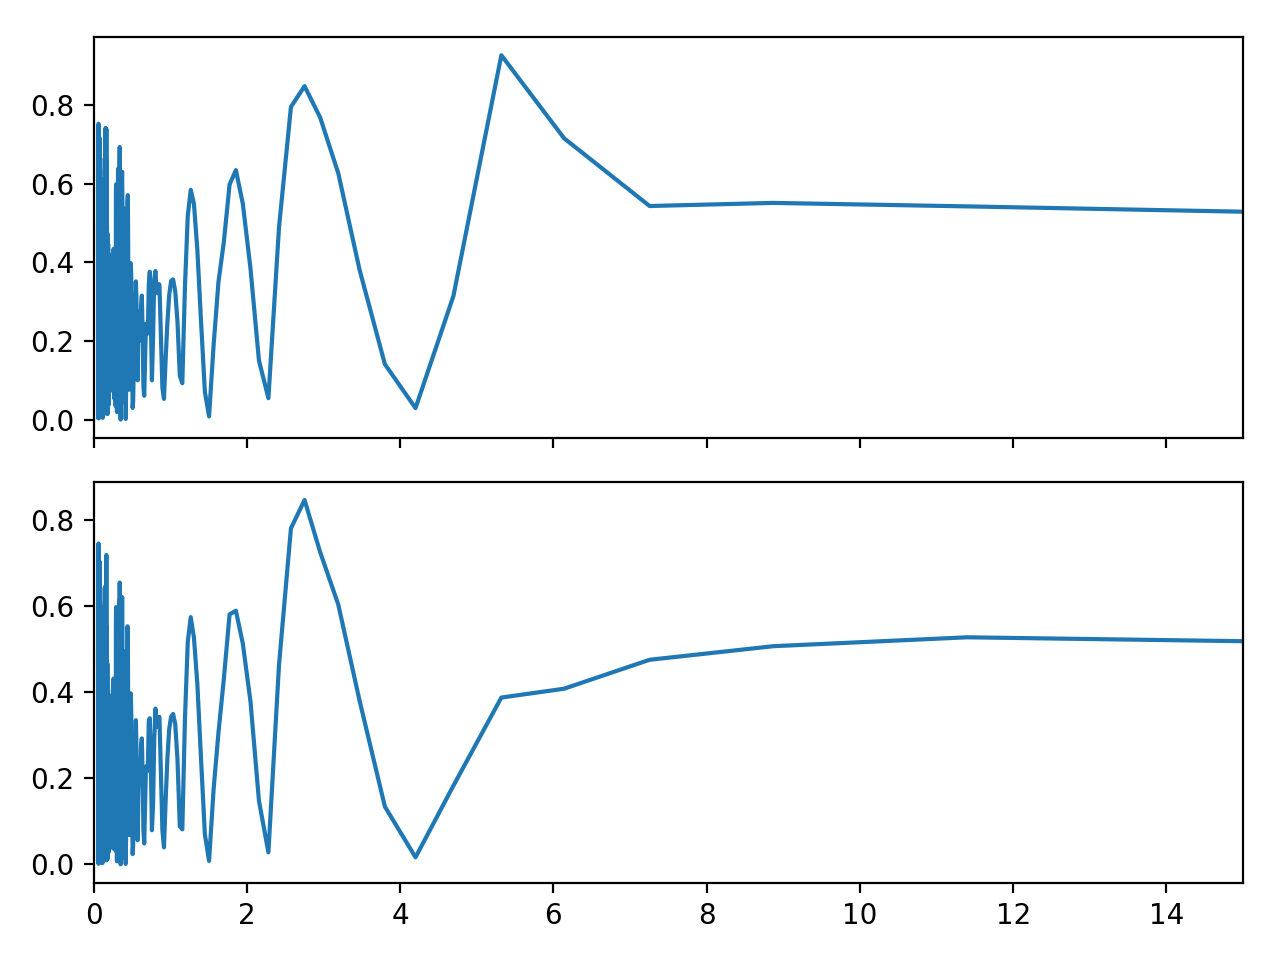

In [83]:
bright = np.where(y > -2)
freq_no_mean, power_no_mean = LombScargle(x[bright], y[bright], y_unc[bright], fit_mean=False).autopower()
freq_fit_mean, power_fit_mean = LombScargle(x[bright], y[bright], y_unc[bright], fit_mean=True).autopower()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(1/freq_fit_mean, power_fit_mean)
ax2.plot(1/freq_no_mean, power_no_mean)
ax1.set_xlim(0,15)

fig.tight_layout()

We can see that the best fit model doesn't match the signal in the case where we do not allow a floating mean.

<IPython.core.display.Javascript object>


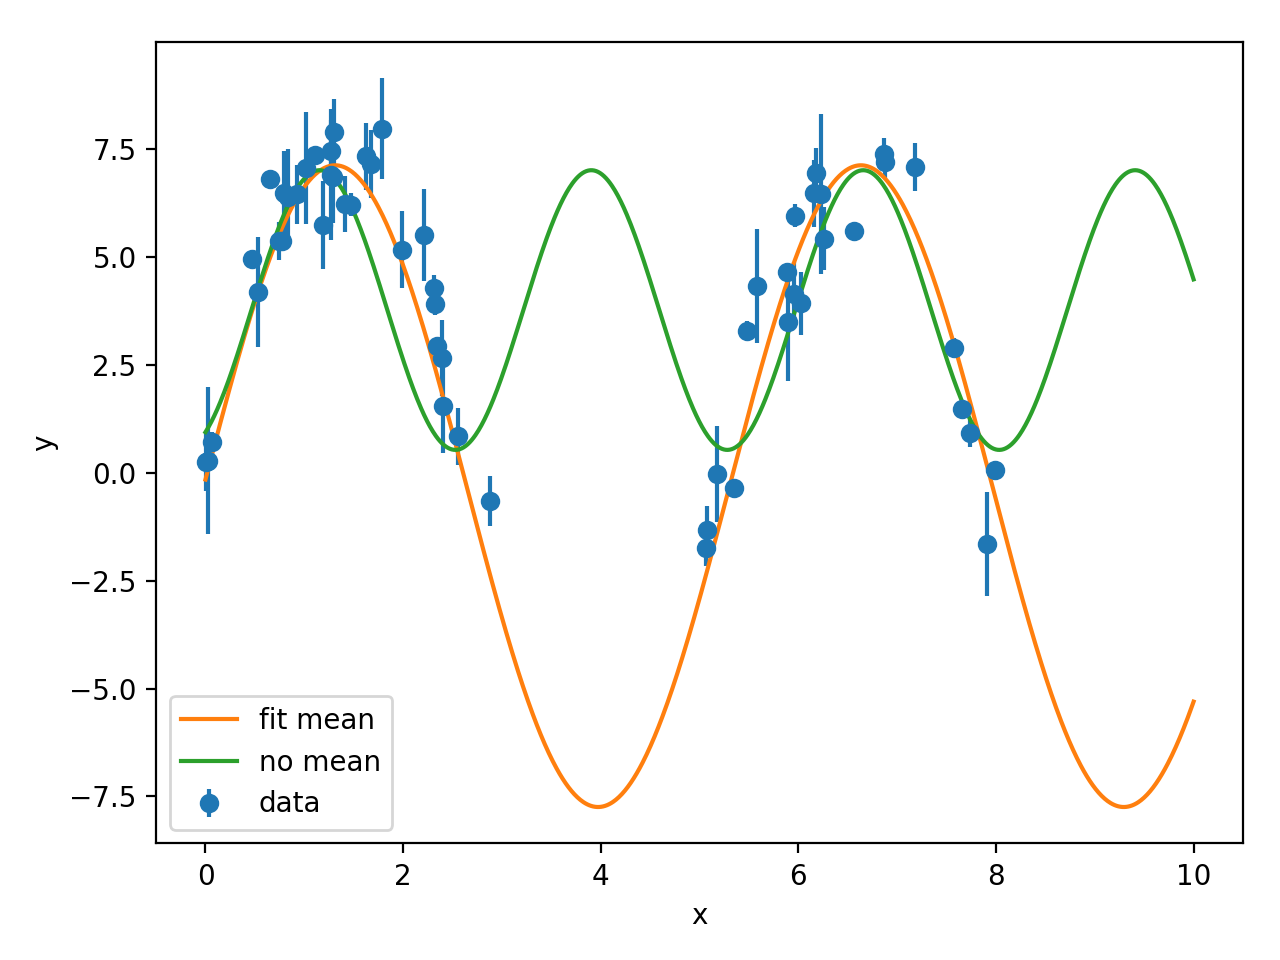

In [84]:
fit_mean_model = LombScargle(x[bright], y[bright], y_unc[bright], 
                             fit_mean=True).model(np.linspace(0,10,1000),
                                                  freq_fit_mean[np.argmax(power_fit_mean)])
no_mean_model = LombScargle(x[bright], y[bright], y_unc[bright], 
                             fit_mean=False).model(np.linspace(0,10,1000),
                                                  freq_no_mean[np.argmax(power_no_mean)])

fig, ax = plt.subplots()
ax.errorbar(x[bright], y[bright], y_unc[bright], fmt='o', label='data')
ax.plot(np.linspace(0,10,1000), fit_mean_model, label='fit mean')
ax.plot(np.linspace(0,10,1000), no_mean_model, label='no mean')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
fig.tight_layout()

### Window Functions

Recall that the convolution theorem tells us that:

$$\mathcal{F}[f\cdot g] = \mathcal{F}(f) \ast \mathcal{F}(g)$$

Telescope observations are effectively the product of a continous signal with several delta functions (corresponding to the times of observations). As a result, the convolution that produces the periodogram will retain signal from both the source and the observational cadence.

To illustrate this effect, let us simulate "realistic" observations for a 10 year telescope survey. We do this by assuming that a source is observed every 3 nights (the LSST cadence) within $\pm 1\,\mathrm{hr}$ of the same time, and that $\sim 30\%$ of the observations did not occur due to bad weather. We further assume that the source cannot be observed for 40% of the year because it is behind the sun.

Simulate a periodic signal with this cadence, a period = 220 days (typical for Miras), amplitude = 12.4, and noise = 1. Plot the simulated light curve.

<IPython.core.display.Javascript object>


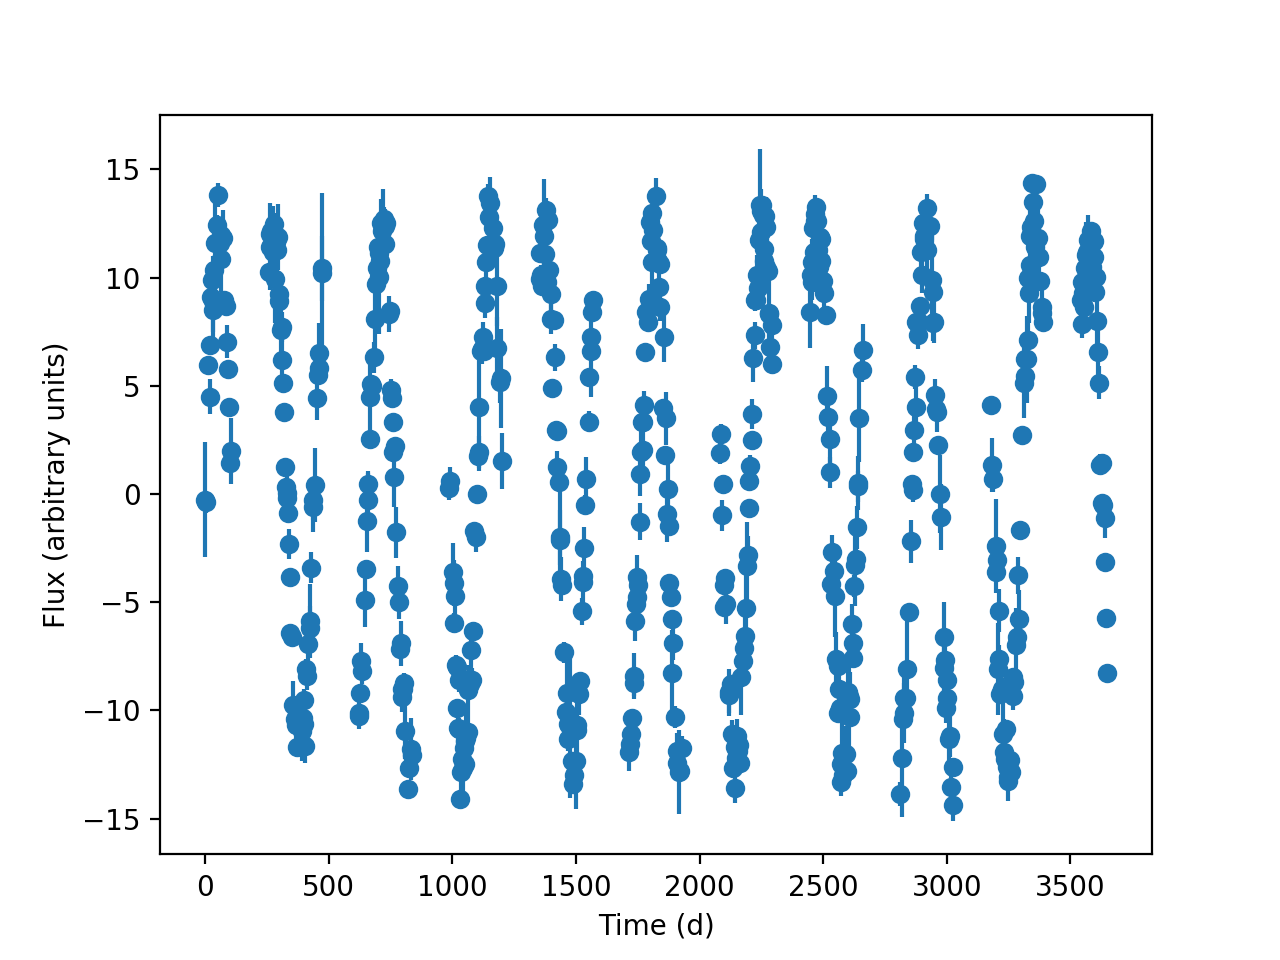

In [117]:
# set up simulated observations
t_obs = np.arange(0, 10*365, 3)      # 3d cadence
t_obs = t_obs + (np.random.rand(len(t_obs))/6 - 1/12)      # rand obs time
t_obs = t_obs[np.logical_or(0.3 > t_obs/365 % 1, t_obs/365 % 1 > 0.7)]      # behind the sun
t_obs = t_obs[np.random.rand(len(t_obs)) <= 0.7]      # bad weather

y = gen_periodic_data(t_obs, period=220, amplitude = 12.4, noise = 1)
y_unc = np.random.normal(0,1,size=len(y))

fig, ax = plt.subplots()
ax.errorbar(t_obs, y, y_unc, fmt='o')
ax.set_xlabel("Time (d)")
ax.set_ylabel("Flux (arbitrary units)")

Calculate and plot the periodogram for the window function of the observations. Do you notice any significant power? 

*Hint* - you may need to zoom in on the plot to see all the relevant features.

<IPython.core.display.Javascript object>


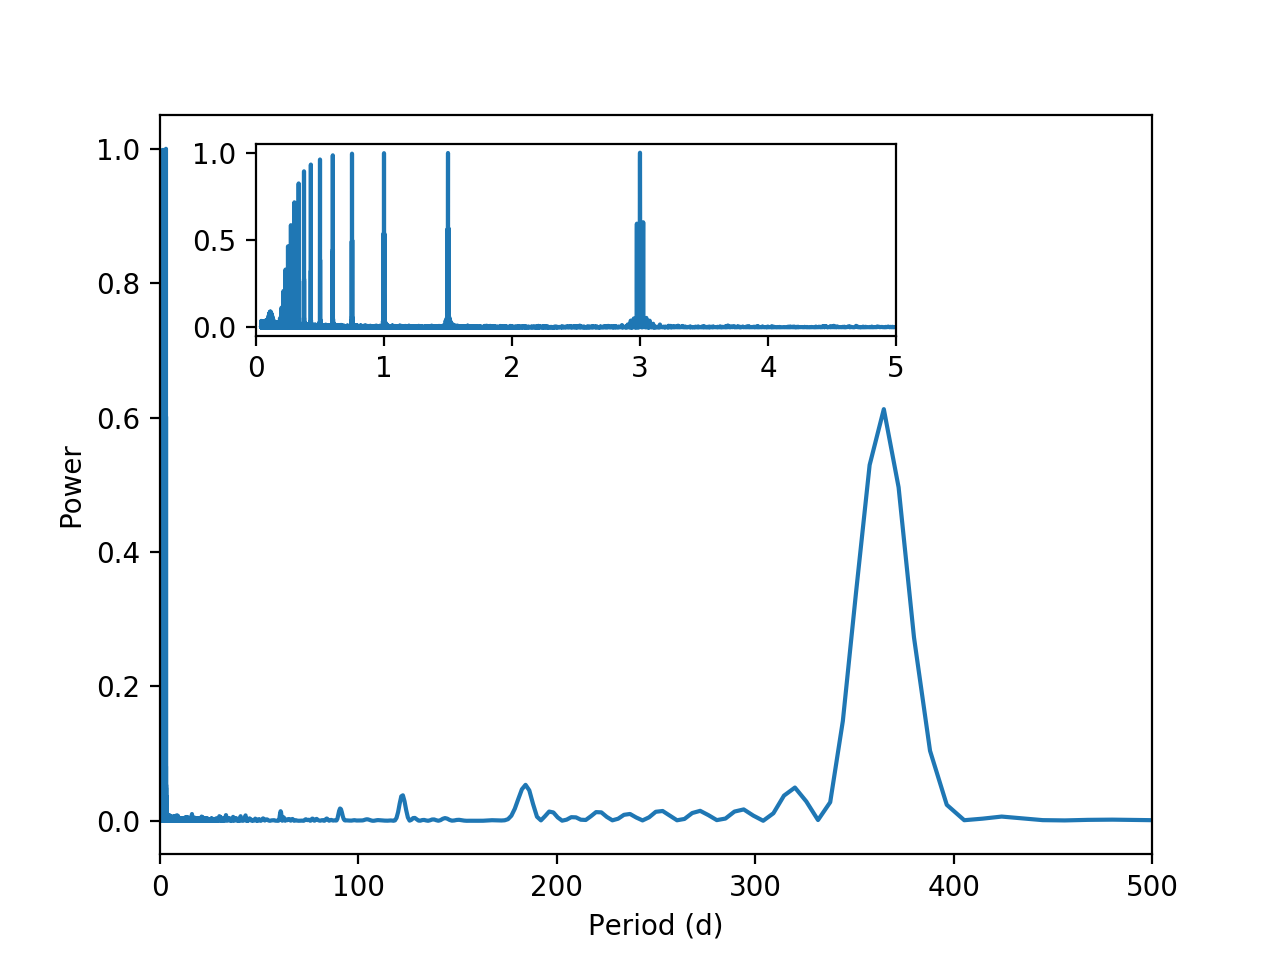

(0, 5)

In [118]:
ls = LombScargle(t_obs, 1, fit_mean=False, center_data=False)

freq_window, power_window = ls.autopower(minimum_frequency=1/3650, maximum_frequency=24)

fig, ax = plt.subplots()
ax.plot(1/freq_window, power_window)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,500)

axins = plt.axes([.2, .65, .5, .2])
axins.plot(1/freq_window, power_window)
axins.set_xlim(0,5)

Interestingly, there are very strong peaks in the data at $P \approx 3\,\mathrm{d} \;\&\; 365\,\mathrm{d}$. 

What is this telling us? Essentially that observations are likely to be repeated at intervals of 3 or 365 days (shorter period spikes are aliases of the 3 d peak).

This is important to understand, however, because this same power will be present in the periodogram where we search for the periodic signal.

Calculate the periodogram for the data and compare it to the periodogram for the window function. 

<IPython.core.display.Javascript object>


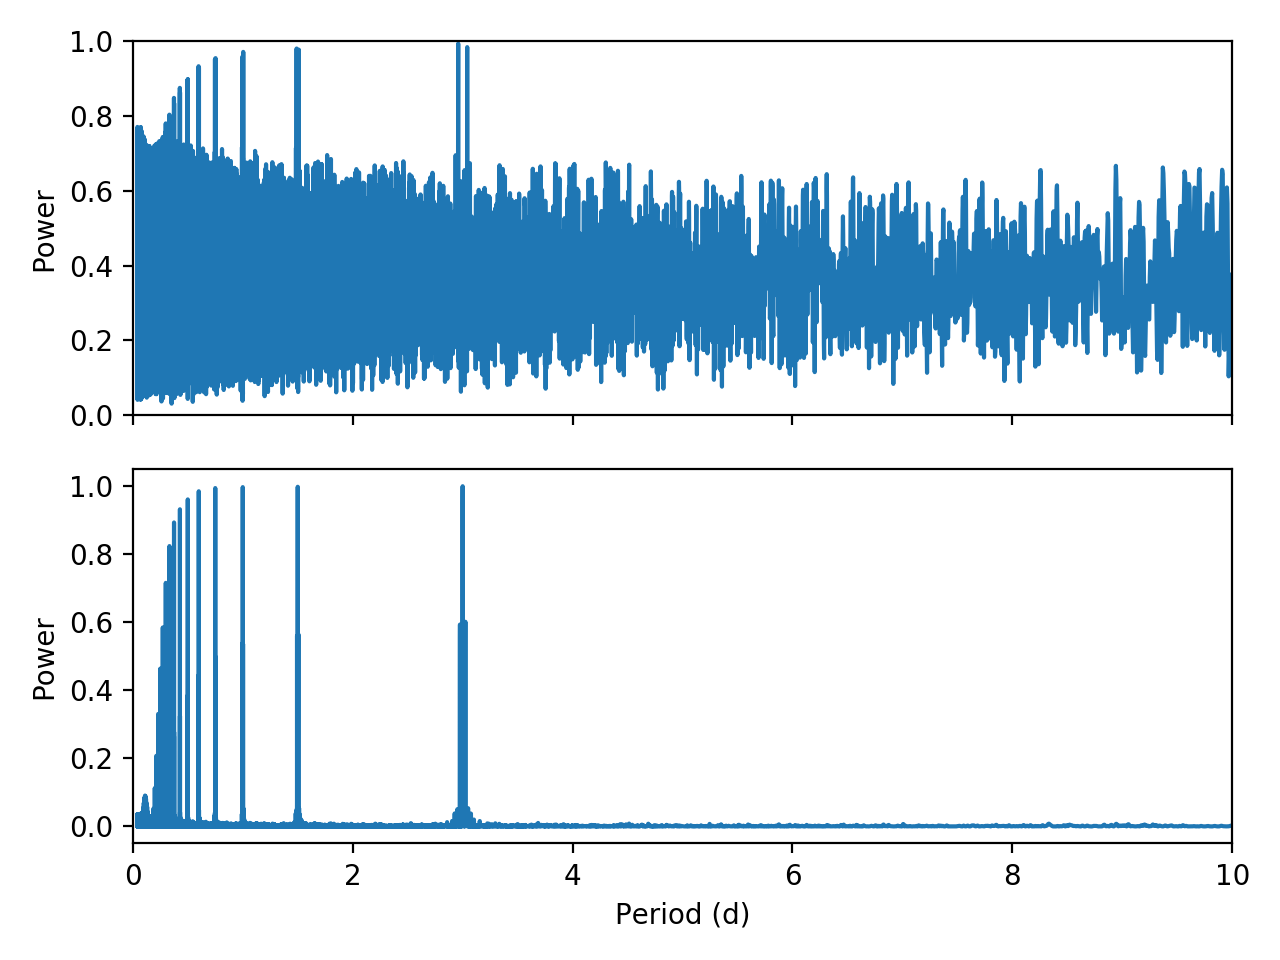

In [121]:
ls = LombScargle(t_obs, y,y_unc)

frequency, power = ls.autopower(minimum_frequency=1/3650, maximum_frequency=24)

fig, (ax,ax2) = plt.subplots(2,1, sharex=True)
ax.plot(1/frequency, power)
ax.set_ylabel("Power")
ax.set_ylim(0,1)

ax2.plot(1/freq_window, power_window)
ax2.set_ylabel("Power")
ax2.set_xlabel("Period (d)")
ax2.set_xlim(0,10)
fig.tight_layout()

### Uncertainty on the best-fit period

How do we report uncertainties on the best-fit period from LS? For example, for the previously simulated LSST light curve we would want to report something like $P = 102 \pm 4\,\mathrm{d}$. However, the uncertainty from LS periodograms cannot be determined in this way. 

Naively, one could report the width of the peak in the periodogram as the uncertainty in the fit. However, we previously saw that the peak width $\propto 1/T$ (the peak width does not decrease as the number of observations or their S/N increases; see Vander Plas 2017). Reporting such an uncertainty is particularly ridiculous for long duration surveys, whereby the peaks become very very narrow.

An alternative approach is to report the False Alarm Probability (FAP), which estimates the probability that a dataset with no periodic signal could produce a peak of similar magnitude, due to random gaussian fluctuations, as the data. 

There are a few different methods to calculate the FAP. Perhaps the most useful, however, is the bootstrap method. To obtain a bootstrap estimate of the LS FAP one leaves the observation times fixed, and then draws new observation values with replacement from the actual set of observations. This procedure is then repeated many times to determine the FAP. 

One nice advantage of this procedure is that any effects due to the window function will be imprinted in each iteration of the bootstrap resampling. 

The major disadvantage is that many many periodograms must be calculated. The rule of thumb is that to acieve a FAP $= p_\mathrm{false}$, one must run $n_\mathrm{boot} \approx 10/p_\mathrm{false}$ bootstrap periodogram calculations. Thus, an FAP $\approx 0.1$ requires an increase of 1000 in computational time. 

`LombScargle` provides the [`false_alarm_probability`](One nice advantage of this procedure is that any effects due to the window function will be imprinted in each iteration of the bootstrap resampling. The major disadvantage is that many many periodograms must be calculated) method, including a bootstrap option. We skip that for now in the interest of time.

As a final note of caution - be weary of over-interpreting the FAP. The specific question answered by the FAP is, what is the probability that gaussian fluctations could produce a signal of equivalent magnitude? Whereas, the question we generally want to answer is: did a periodic signal produce these data?

These questions are very different, and thus, the FAP cannot be used to *prove* that a source is periodic.

### Real world considerations

We have covered many, though not all, considerations that are necessary when employing a Lomb Scargle periodogram. We have not yet, however, encountered real world data. Here we highlight some of the issues associated with astronomical light curves. 

We will now use LS to analyze actual data from the [All Sky Automated Survey (ASAS)](http://www.astrouw.edu.pl/asas/?page=catalogues).

Read in the light curve from lc8.dat. Plot the light curve.

*Hint* - I recommend using `astropy Tables` or `pandas dataframe`.

<IPython.core.display.Javascript object>


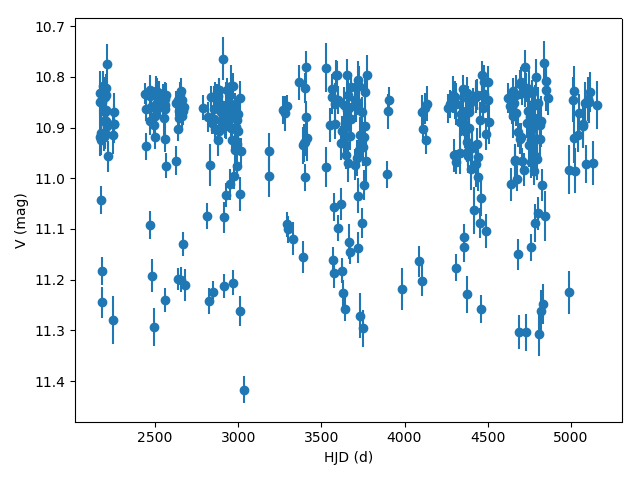

In [299]:
data = pd.read_csv("lc8.dat")

fig, ax = plt.subplots()
ax.errorbar(data['hjd'], data['mag'], data['mag_unc'], fmt='o')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('V (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

Use `LombScargle` to measure the periodogram. Then plot the periodogram and the phase folded light curve at the best-fit period.

*Hint* - search periods longer than 2 hr.

<IPython.core.display.Javascript object>


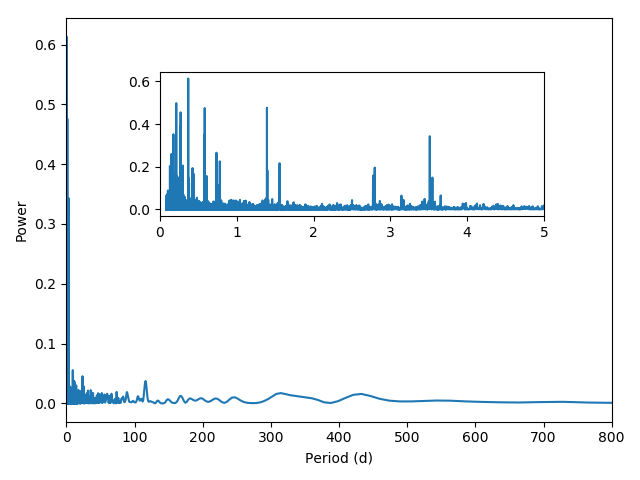

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [304]:
frequency, power = LombScargle(data['hjd'], data['mag'], data['mag_unc']).autopower(maximum_frequency=12)

ls_period = 1/frequency[np.argmax(power)]

fig,ax = plt.subplots()

ax.plot(1/frequency, power)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0, 800)

axins = plt.axes([.25, .55, .6, .3])
axins.plot(1/frequency, power)
axins.set_xlim(0,5)
fig.tight_layout()

<IPython.core.display.Javascript object>


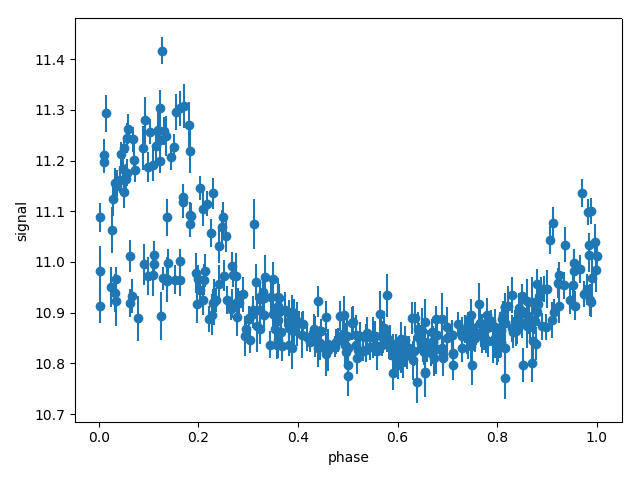

In [301]:
phase_plot(data['hjd'], data['mag'], ls_period, data['mag_unc'])

Now plot the light curve folded at double the best LS period.

Which of these 2 is better? 

<IPython.core.display.Javascript object>


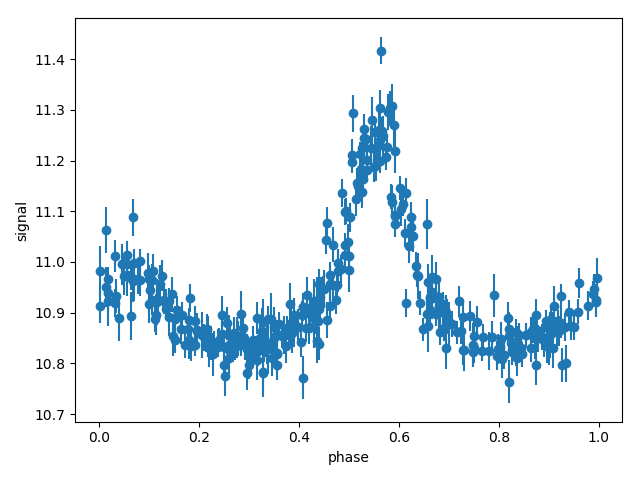

In [302]:
phase_plot(data['hjd'], data['mag'], 2*ls_period, data['mag_unc'])

Herein lies a fundamental issue regarding the LS periodogram: the model does not search for "periodicity." The LS model asks if the data support a sinusoidal signal. As astronomers we typically assume this question is good enough, but as we can see in the example of this eclipsing binary that is not the case [and this is not limited to eclipsing binaries]. 

We can see why LS is not sufficient for an EB by comparing the model to the phase-folded light curve:

<IPython.core.display.Javascript object>


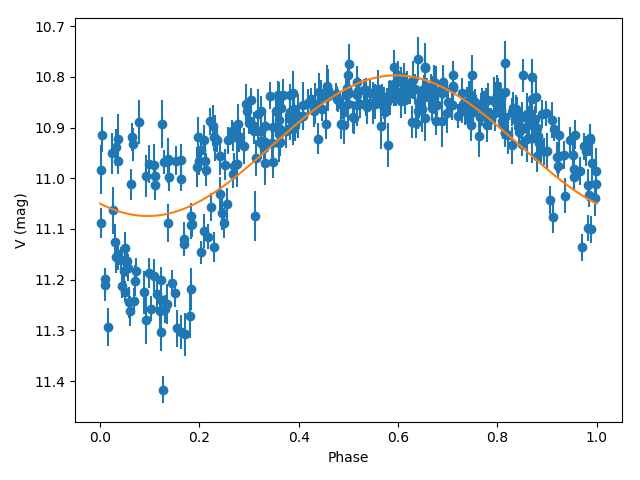

In [305]:
fig, ax = plt.subplots()

ax.errorbar(data['hjd']/ls_period % 1, data['mag'], data['mag_unc'], fmt='o', zorder=-1)
ax.plot(np.linspace(0,1,1000), 
        LombScargle(data['hjd'],data['mag'], data['mag_unc']).model(np.linspace(0,1,1000)*ls_period, 1/ls_period) )
ax.set_xlabel('Phase')
ax.set_ylabel('V (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

One way to combat this very specific issue is to include more Fourier terms at the harmonic of the best fit period. This is easy to implement in `LombScargle` with the `nterms` keyword. [Though always be weary of adding degrees of freedom to a model, especially at the large pipeline level of analysis.]

Calculate the LS periodogram for the eclipsing binary, with `nterms` = 1, 2, 3, 4, 5. Report the best-fit period for each of these models.

*Hint* - we have good reason to believe that the best fit frequency is < 1 in this case, so set `maximum_frequency = 1`.

In [307]:
for i in np.arange(1,6):
    frequency, power = LombScargle(data['hjd'], data['mag'], data['mag_unc'], nterms=i).autopower(maximum_frequency=3)
    ls_period = 1/frequency[np.argmax(power)]
    print('For {:d} harmonics, P_LS = {:.8f}'.format(i, ls_period))

For 1 harmonics, P_LS = 0.36753832
For 2 harmonics, P_LS = 0.73508568
For 3 harmonics, P_LS = 0.73508568
For 4 harmonics, P_LS = 0.73508568
For 5 harmonics, P_LS = 0.49864292


Interestingly, for $n=2, 3, 4$ harmonics, it appears as though we get the period that we have visually confirmed. However, by $n=5$ harmonics we no longer get a reasonable answer. Again - be very careful about adding harmonics, especially in large analysis pipelines.

What does the $n = 4$ model look like?

<IPython.core.display.Javascript object>


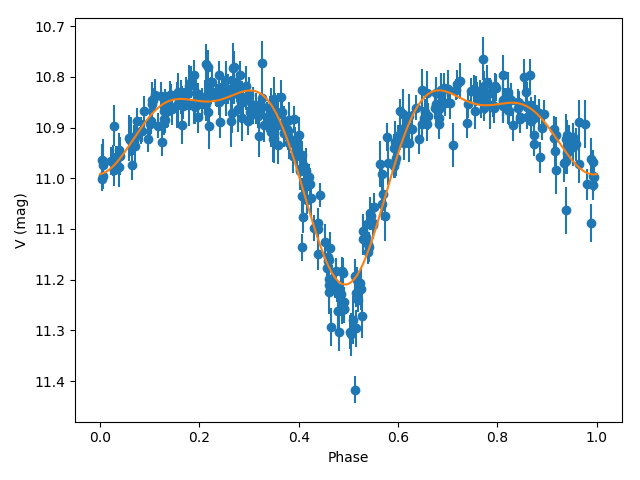

In [319]:
best_period = 0.73508568

fig, ax = plt.subplots()

ax.errorbar((data['hjd'])/best_period % 1, data['mag'], data['mag_unc'], fmt='o',zorder=-1)
ax.plot(np.linspace(0,1,1000), 
        LombScargle(data['hjd'],data['mag'], data['mag_unc'], 
                    nterms=4).model(np.linspace(0,1,1000)*best_period, 1/best_period) )
ax.set_xlabel('Phase')
ax.set_ylabel('V (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

This example also shows why it is somewhat strange to provide an uncertainty with a LS best-fit period. Errors tend to be catastrophic, and not some small fractional percentage, with the LS periodogram (we'll explore this a little further). 

In the case of the above EB, the "best-fit" period was off by a factor 2. This is not isolated to EBs, however, LS periodograms frequently identify a correct harmonic of the true period, but not the actual period of variability. 

## Conclusions

The Lomb-Scargle periodogram is a useful tool to search for *sinusoidal* signals in noisy, irregular data. 

However, as highlighted throughout, there are many ways in which the methodology can run awry.

In closing, I will summarize some practical considerations from VanderPlas (2017): 

  1. Choose an appropriate frequency grid (defaults in `LombScargle` are not sufficient)
  2. Calculate the LS periodogram for the observation times to search for dominant signals (e.g., 1 day in astro)
  3. Compute LS periodogram for data (avoid multi-Fourier models if signal unknown)
  4. Plot periodogram and various FAP levels (do not over-interpret FAP)
  5. If window function shows strong aliasing, plot phased light curve at each peak (now add more Fourier terms if necessary)
  6. If looking for a particular signal (e.g., detatched EBs), consider different methods that better match expected signal
  7. Inject fake signals into data to understand systematics if using LS in a survey pipeline

### Finally, Finally

As a very last note: know that there are many different ways to search for periodicity in astronomical data. Depending on your application (and computational resources), LS may be a poor choice (even though this is often the default choice by all astronomers!) [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) provides a summary of several using actual astronomical data. The results of that study show that no single method is best. However, they also show that no single method performs particularly well: the detection efficiences in Graham et al. (2013) are disappointing given the importance of periodicity in astronomical signals.

Period detection is a fundamental problem for astronomical time-series, but it is especially difficult in "production" mode. Be careful when setting up pipelines to analyze large datasets.  

**Challenge Problem**

Alter `gen_periodic_data` to create signals with 4 harmonics. 

Using our prescription for a simulated "realistic" astronomical cadence (see above), simulate 2 years worth of survey data for 1000 simulated stars with periods drawn randomly from [0.2, 10], amplitude=1, noise=0.01. 

Compare the best-fit LS period to the simulated period. Do you notice any particular trends?

In [294]:
from astropy.table.table import Table
from astropy.io import ascii
with open("EB8_example.dat") as f:
    ll = f.readlines()
for lnum, l in enumerate(ll):
    if l[0:15] == "#dataset= 3 ; 3":
        nskip = lnum
        
lc = Table.read("EB8_example.dat", data_start=nskip,format="ascii")
lc_df = lc[['col1','col6','col11']].to_pandas().rename(index=str, 
                                                       columns={"col1": "hjd", "col6": "mag", "col11": "mag_unc"})

det = np.logical_and(lc['col12'] != 'D', lc_df['mag'] < 16)
lc_df[det].to_csv("lc8.dat", index = False)

## Code from [PracticalLombScargle](https://github.com/jakevdp/PracticalLombScargle/) by Jake Van der Plas

The functions below implement plotting routines developed by Jake to illustrate some properties of Fourier transforms. 

This code is distributed under a BSD-3 licence, which is repeated below: 

Copyright (c) 2015, Jake Vanderplas
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of PracticalLombScargle nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [28]:
def fourier_pairs_plot():
    
    fig, ax = plt.subplots(4, 2, figsize=(10, 6))
    fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.95,
                        hspace=0.3, wspace=0.2)

    x = np.linspace(-5, 5, 1000)

    for axi in ax.flat:
        axi.xaxis.set_major_formatter(plt.NullFormatter())
        axi.yaxis.set_major_formatter(plt.NullFormatter())

        # draw center line
        axi.axvline(0, linestyle='dotted', color='gray')
        axi.axhline(0, linestyle='dotted', color='gray')

    style_re = dict(linestyle='solid', color='k', linewidth=2)
    style_im = dict(linestyle='solid', color='gray', linewidth=2)
    text_style = dict(size=14, color='gray')


    # sine -> delta
    ax[0, 0].plot(x, np.cos(x),**style_re)
    ax[0, 0].set(xlim=(-5, 5), ylim=(-1.2, 1.2))
    ax[0, 0].annotate('', (-np.pi, 0), (np.pi, 0),
                      arrowprops=dict(arrowstyle='|-|', color='gray'))
    ax[0, 0].text(0, 0, '$1/f_0$', ha='center', va='bottom', **text_style)
    ax[0, 0].set_title('Sinusoid')

    ax[0, 1].plot([-5, 2, 2, 2, 5], [0, 0, 1, 0, 0], **style_re)
    ax[0, 1].plot([-5, -2, -2, -2, 5], [0, 0, 1, 0, 0], **style_re)
    ax[0, 1].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[0, 1].annotate('', (0, 0.4), (2, 0.4), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[0, 1].annotate('', (0, 0.4), (-2, 0.4), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[0, 1].text(1, 0.45, '$+f_0$', ha='center', va='bottom', **text_style)
    ax[0, 1].text(-1, 0.45, '$-f_0$', ha='center', va='bottom', **text_style)
    ax[0, 1].set_title('Delta Functions')

    # gaussian -> gaussian
    ax[1, 0].plot(x, np.exp(-(2 * x) ** 2), **style_re)
    ax[1, 0].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[1, 0].annotate('', (0, 0.35), (0.6, 0.35), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[1, 0].text(0, 0.4, '$\sigma$', ha='center', va='bottom', **text_style)
    ax[1, 0].set_title('Gaussian')

    ax[1, 1].plot(x, np.exp(-(x / 2) ** 2), **style_re)
    ax[1, 1].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[1, 1].annotate('', (0, 0.35), (2, 0.35), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[1, 1].text(0, 0.4, '$(2\pi\sigma)^{-1}$', ha='center', va='bottom', **text_style)
    ax[1, 1].set_title('Gaussian')

    # top hat -> sinc
    ax[2, 0].plot([-2, -1, -1, 1, 1, 2], [0, 0, 1, 1, 0, 0], **style_re)
    ax[2, 0].set(xlim=(-2, 2), ylim=(-0.3, 1.2))
    ax[2, 0].annotate('', (-1, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[2, 0].text(0.0, 0.5, '$T$', ha='center', va='bottom', **text_style)
    ax[2, 0].set_title('Top Hat')

    ax[2, 1].plot(x, np.sinc(x), **style_re)
    ax[2, 1].set(xlim=(-5, 5), ylim=(-0.3, 1.2))
    ax[2, 1].annotate('', (-1, 0), (1, 0), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[2, 1].text(0.0, 0.0, '$2/T$', ha='center', va='bottom', **text_style)
    ax[2, 1].set_title('Sinc')

    # comb -> comb
    ax[3, 0].plot([-5.5] + sum((3 * [i] for i in range(-5, 6)), []) + [5.5],
                  [0] + 11 * [0, 1, 0] + [0], **style_re)
    ax[3, 0].set(xlim=(-5.5, 5.5), ylim=(-0.2, 1.2))
    ax[3, 0].annotate('', (0, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[3, 0].text(0.5, 0.6, '$T$', ha='center', va='bottom', **text_style)
    ax[3, 0].set_title('Dirac Comb')

    ax[3, 1].plot([-5.5] + sum((3 * [i] for i in range(-5, 6)), []) + [5.5],
                  [0] + 11 * [0, 1, 0] + [0], **style_re)
    ax[3, 1].set(xlim=(-2.5, 2.5), ylim=(-0.2, 1.2));
    ax[3, 1].annotate('', (0, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[3, 1].text(0.5, 0.6, '$1/T$', ha='center', va='bottom', **text_style)
    ax[3, 1].set_title('Dirac Comb')

    for i, letter in enumerate('abcd'):
        ax[i, 0].set_ylabel('({0})'.format(letter), rotation=0)

    # Draw arrows between pairs of axes
    for i in range(4):
        left = ax[i, 0].bbox.inverse_transformed(fig.transFigure).bounds
        right = ax[i, 1].bbox.inverse_transformed(fig.transFigure).bounds
        x = 0.5 * (left[0] + left[2] + right[0])
        y = left[1] + 0.5 * left[3]
        fig.text(x, y, r'$\Longleftrightarrow$',
                 ha='center', va='center', size=30)